# Explaining correlations with assumed or discovered causal models

A common task in causal discovery is to justify and validate why an assumed or reconstructed causal network makes sense. Here we show how one can use the estimated graph to construct a model that explains the lagged correlation structure of the dataset. The steps are as follows

1. Estimate (Markov equivalence class of) causal graph
2. If Markov equivalence class has more than one member (unoriented edges occur), pick one member of the class, which can be automated
3. Fit linear structural causal model to causal parents taken from graph
4. Estimate noise covariance matrix of residuals
5. Construct linear Gaussian structural causal model with this noise structure and generate many realizations with same sample size as data
6. Show lagged correlations of original data with the (ensemble mean and confidence interval) lagged correlations of the generated data

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite.toymodels import surrogate_generator 

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.models import Models, Prediction

import math
import sklearn
from sklearn.linear_model import LinearRegression


## 0. Generate some example process with contemporaneous dependencies

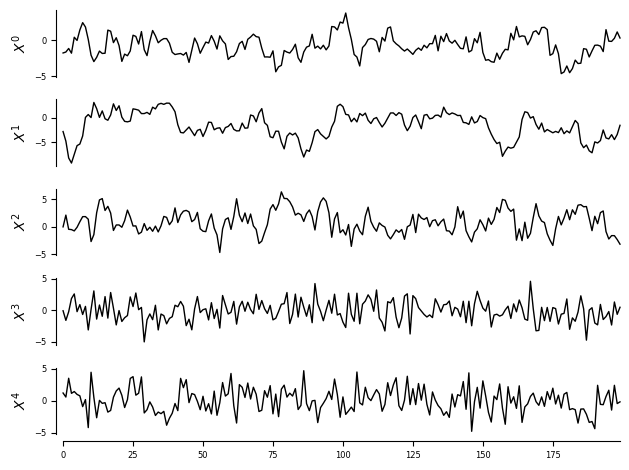

In [2]:
np.random.seed(14)     # Fix random seed
lin_f = lambda x: x
links_coeffs = {0: [((0, -1), 0.7, lin_f)],
                1: [((1, -1), 0.8, lin_f), ((0, -1), 0.3, lin_f)],
                2: [((2, -1), 0.5, lin_f), ((0, -2), -0.5, lin_f)],
                3: [((3, -1), 0., lin_f)], #, ((4, -1), 0.4, lin_f)],
                4: [((4, -1), 0., lin_f), ((3, 0), 0.5, lin_f)], #, ((3, -1), 0.3, lin_f)],
                }
T = 200     # time series length
# Make some noise with different variance, alternatively just noises=None
noises = np.array([(1. + 0.2*float(j))*np.random.randn((T + int(math.floor(0.2*T)))) 
                   for j in range(len(links_coeffs))]).T

data, _ = toys.structural_causal_process(links_coeffs, T=T, noises=noises, seed=14)
T, N = data.shape

# For generality, we include some masking
# mask = np.zeros(data.shape, dtype='int')
# mask[:int(T/2)] = True
mask=None

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$', r'$X^4$']
dataframe = pp.DataFrame(data, 
                         mask=mask,
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)
tp.plot_timeseries(dataframe=dataframe); plt.show()

Now let's look at the lagged correlations matrix. We want to find a structural causal model that explains it.

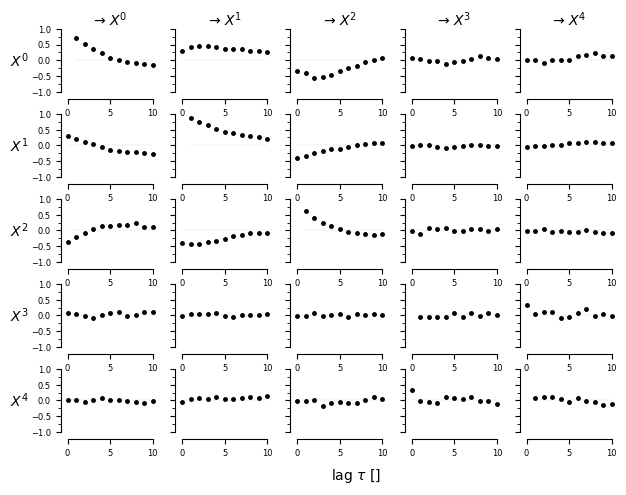

In [3]:
tau_max = 10
parcorr = ParCorr(significance='analytic', 
#                   mask_type='y'
                 )
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=0)
original_correlations = pcmci.get_lagged_dependencies(tau_max=tau_max, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=original_correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

## 1. Estimate (Markov equivalence class of) causal graph

Here we run PCMCI+ with some reasonable `tau_max` and `pc_alpha`. Of course, the estimated model will slightly depend on these parameters

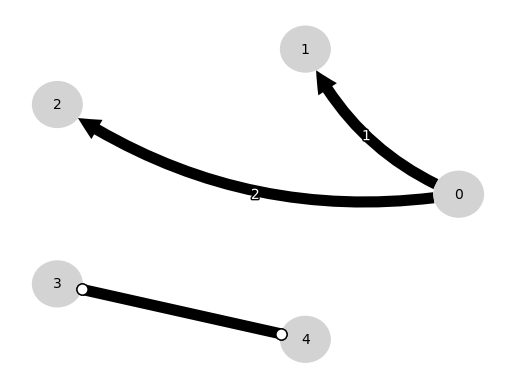

In [4]:
results = pcmci.run_pcmciplus(tau_max=tau_max, pc_alpha=0.01)
tp.plot_graph(results['graph']); plt.show()

## 2. If Markov equivalence class has more than one member (unoriented edges occur), pick one member of the class, which can be automated

The result of PCMCI+ is a CPDAG (unoriented edge occurs). We pick one DAG member of this class with some internal functions. 

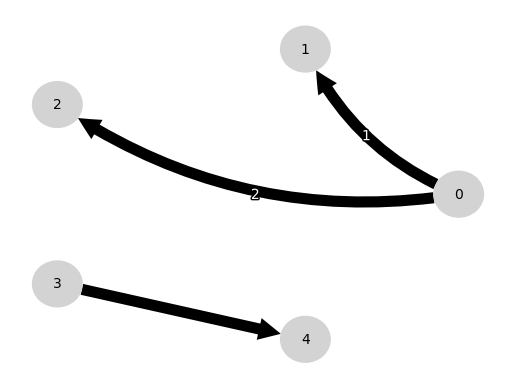

In [5]:
# First create order that is based on some feature of the variables
# to avoid order-dependence of DAG, i.e., it should not matter
# in which order the variables appear in dataframe
# Here we use the sum of absolute val_matrix values incident at j
val_matrix = results['val_matrix']
variable_order = np.argsort(
                    np.abs(val_matrix).sum(axis=(0,2)))[::-1]

# Transform conflicting links to unoriented links as a hack, might not work...
graph = results['graph']
graph[graph=='x-x'] = 'o-o'
dag = pcmci._get_dag_from_cpdag(
                cpdag_graph=graph,
                variable_order=variable_order)

tp.plot_graph(dag); plt.show()

The following steps are all wrapped in the function ``generate_linear_model_from_data`` from the module   ``toymodels.surrogate_generator``.

## 3. Fit linear structural causal model to causal parents taken from graph

Using the Prediction class which calls Models().

## 4. Estimate noise covariance matrix of residuals

Using the Prediction class.

## 5. Construct linear Gaussian structural causal model with this noise structure 

In [6]:
parents = toys.dag_to_links(dag)
print(parents)

{0: [(0, -1)], 1: [(0, -1), (1, -1)], 2: [(0, -2), (2, -1)], 3: [], 4: [(3, 0)]}


## Now generate many realizations with same sample size as data

In [7]:
realizations = 100

generator = surrogate_generator.generate_linear_model_from_data(dataframe, parents, tau_max, realizations=realizations, 
                generate_noise_from='covariance')
datasets = {}
for r in range(realizations):
    datasets[r] = next(generator)

/home/jakobrunge/anaconda3/envs/py39/lib/python3.9/site-packages/tigramite-5.2.0.1-py3.9.egg/tigramite/models.py:1693: UserWarning: test_indices - maxlag(predictors) [or tau_max] overlaps with train_indices: Choose test_indices such that there is a gap of max_lag to train_indices!


## 6. Show lagged correlations of original data with the (ensemble mean and confidence interval) lagged correlations of the generated data

In [8]:
correlations = np.zeros((realizations, N, N, tau_max + 1))
for r in range(realizations):
    pcmci = PCMCI(
        dataframe=pp.DataFrame(datasets[r]), 
        cond_ind_test=ParCorr(),
        verbosity=0)
    correlations[r] = pcmci.get_lagged_dependencies(tau_max=tau_max, val_only=True)['val_matrix']

In [9]:
# Get mean and 5th and 95th quantile
correlation_mean = correlations.mean(axis=0)
correlation_interval = np.percentile(correlations, q=[5, 95], axis=0)

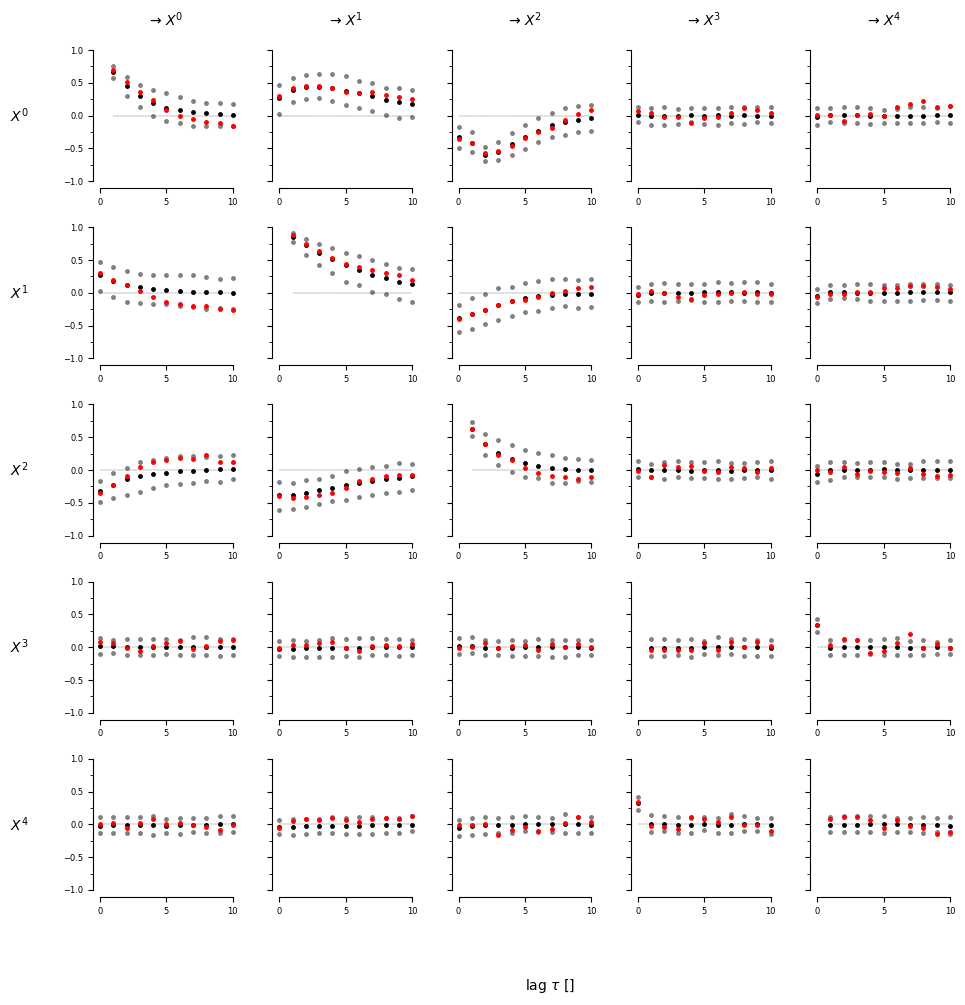

In [10]:
# Plot lag functions of mean and 5th and 95th quantile together with original correlation in one plot
lag_func_matrix = tp.setup_matrix(N=N, tau_max=tau_max, x_base=5, figsize=(10, 10), var_names=var_names)
lag_func_matrix.add_lagfuncs(val_matrix=correlation_mean, color='black')
lag_func_matrix.add_lagfuncs(val_matrix=correlation_interval[0], color='grey')
lag_func_matrix.add_lagfuncs(val_matrix=correlation_interval[1], color='grey')
lag_func_matrix.add_lagfuncs(val_matrix=original_correlations, color='red')
lag_func_matrix.savefig(name=None)

The original lag function in red should now be roughly inside the 90% range (grey) of the correlations of the generated data. Voila, this means that a linear Gaussian model with the same links (and estimated coefficients and noise structure) as those from the reconstructed causal graph can well explain the whole lagged correlation structure of the original data. Hence, it is a causal parsimonious model that explains the data.

Finally, we can also show the (convoluted) correlation graph.

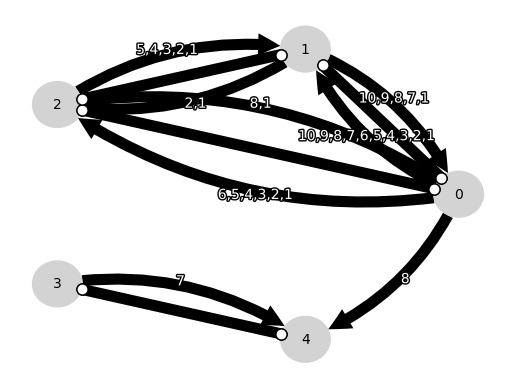

In [11]:
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=0)
original_correlations_pvals = pcmci.get_lagged_dependencies(tau_max=tau_max)['p_matrix'] 
tp.plot_graph(graph=original_correlations_pvals<=0.01); plt.show()